# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.179870,False,2.352941
1,1.091804,True,5.020821
2,-1.425131,False,-1.004849
3,1.232988,True,7.471564
4,0.386888,True,6.457970
...,...,...,...
995,-0.552839,True,5.027234
996,-1.196430,False,0.195735
997,-0.325908,False,-1.952912
998,0.654461,True,5.025176


<AxesSubplot: xlabel='v0'>

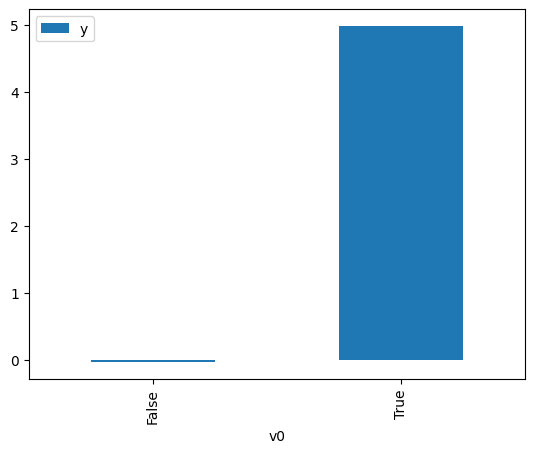

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

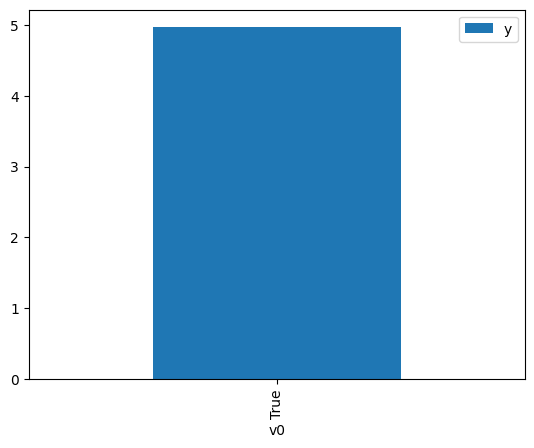

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.485169,False,-0.729670,0.671205,1.489857
1,-0.874488,False,-0.205620,0.771717,1.295811
2,-0.800464,False,-0.657890,0.754384,1.325586
3,1.855258,False,-1.045349,0.089598,11.161023
4,-1.118811,False,0.962792,0.822674,1.215548
...,...,...,...,...,...
995,0.096517,False,-0.230260,0.490007,2.040787
996,0.613892,False,-1.827916,0.329538,3.034550
997,0.369880,False,0.467257,0.402721,2.483108
998,0.360720,False,-1.648494,0.405579,2.465611


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.503011,True,4.897740,0.323714,3.089150
1,0.982050,True,5.434514,0.766249,1.305058
2,0.463243,True,6.210679,0.626001,1.597442
3,1.667946,True,4.871652,0.888537,1.125446
4,0.174277,True,4.800589,0.535122,1.868731
...,...,...,...,...,...
995,0.873019,True,4.697564,0.740005,1.351343
996,1.584807,True,6.157012,0.877414,1.139713
997,0.760098,True,6.038296,0.710887,1.406693
998,-0.077367,True,5.133788,0.453806,2.203583


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              6532.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                        0.00
Time:                        15:13:43   Log-Likelihood:                         -1433.5
No. Observations:                1000   AIC:                                      2871.
Df Residuals:                     998   BIC:                                      2881.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3761      0.036     10.402      0.000       0.305       0.447
x2             4.8851      0.050     98.590      0.000       4.788       4.982
==============================================================================
Omnibus:                        0.480   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.568
Skew:                           0.025   Prob(JB):                        0.753
Kurtosis:                       2.894   Cond. No.                         1.75
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""